<a href="https://colab.research.google.com/github/CassioLima09/NLP_with_Transformers/blob/main/04_multilingual-ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Uncomment and run this cell if you're on Colab or Kaggle
!git clone https://github.com/nlp-with-transformers/notebooks.git
%cd notebooks
from install import *
install_requirements()

Cloning into 'notebooks'...
remote: Enumerating objects: 530, done.
remote: Counting objects: 100% (209/209), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 530 (delta 184), reused 162 (delta 162), pack-reused 321 (from 2)
Receiving objects: 100% (530/530), 28.52 MiB | 10.03 MiB/s, done.
Resolving deltas: 100% (253/253), done.
/content/notebooks
⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [ ]:
#hide
from utils import *
setup_chapter()

Using transformers v4.16.2
Using datasets v1.16.1


## Zero shot learning

In [ ]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification")

text = "O serviço foi incrivelmente rápido e eficiente."
labels = ["positivo", "negativo", "neutro"]

result = classifier(text, candidate_labels=labels)
print(result)


No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


Downloading:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:1435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(resolved_archive_file, map

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


{'sequence': 'O serviço foi incrivelmente rápido e eficiente.', 'labels': ['positivo', 'neutro', 'negativo'], 'scores': [0.9359259605407715, 0.05429922416806221, 0.009774825535714626]}


# Multilingual Named Entity Recognition
Vamos criar um algoritmo que reconhece entidades em diferentes idiomas, como frances italiano, alemão

## The Dataset

In [ ]:
#id jeff-dean-ner
#caption An example of a sequence annotated with named entities
#hide_input


import pandas as pd
toks = "Jeff Dean is a computer scientist at Google in California".split()
lbls = ["B-PER", "I-PER", "O", "O", "O", "O", "O", "B-ORG", "O", "B-LOC"]
df = pd.DataFrame(data=[toks, lbls], index=['Tokens', 'Tags'])
df

# o prefixo -B indica o começo da entidade e I- indica que aquele tokent tbm faz parte
# da entidade. -O indica que a palavra nao é uma entidade

Tokens,Jeff,Dean,is,a,computer,scientist,at,Google,in,California
Tags,B-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC


In [ ]:
from datasets import get_dataset_config_names
# vamos usara subset of the Cross-lingual TRansfer Evaluation of Multilingual Encoders (XTREME)
# precisamos saber quantas configurações possiveis ele tem
xtreme_subsets = get_dataset_config_names("xtreme")
print(f"XTREME has {len(xtreme_subsets)} configurations")

XTREME has 183 configurations


In [ ]:
panx_subsets = [s for s in xtreme_subsets if s.startswith("PAN")]
panx_subsets[:3]

# sao muitas configurações, vamos buscar uma que começa com 'PAN' e provavelemtne vamos ter um multilingue interessante

['PAN-X.af', 'PAN-X.ar', 'PAN-X.bg']

In [ ]:
# hide_output
from datasets import load_dataset

load_dataset("xtreme", name="PAN-X.de")

# vamso importar o dataset

  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs'],
        num_rows: 20000
    })
})

In [ ]:
# hide_output
from collections import defaultdict
from datasets import DatasetDict


#Exist um desbalanceamento entre os que falam idiomas na suiça e  por isso vamos criar o fracs
# fracs é a distribuição percentual de falantes do idioma dentro da suiça
langs = ["de", "fr", "it", "en"]
fracs = [0.629, 0.229, 0.084, 0.059]
# Return a DatasetDict if a key doesn't exist
panx_ch = defaultdict(DatasetDict)

# a distribuição do dataset deve incorporar essas caracteristicas de desbalanceamento de falantes

for lang, frac in zip(langs, fracs): # vai receber o idioma e a proporção correspondente
    # Load monolingual corpus
    ds = load_dataset("xtreme", name=f"PAN-X.{lang}")# vamos carregar um dataset por idioma
  # "xtreme" → Nome do dataset geral (uma coleção de datasets multilingues para diversas tarefas de NLP).
  # Exemplo: name="PAN-X.fr" → Seleciona somente os exemplos em francês do conjunto PAN-X.
    # Shuffle and downsample each split according to spoken proportion
    for split in ds: # aqui vai percorrer o dataset , que e dividido em treino validação e tesete

# Importante, ele vai agora distribuir os datasets de forma que eles mantenham a porporçao de exemplos para a proporçao de falantes da lingua
# eu acho que ele deveria usar o tamanho de todo o dataset para considerar o frac e nao apenas segmentar dentro do dataset do idioma em si
# isso porque os datasets podem variar de tamanho
        panx_ch[lang][split] = (
            ds[split]
            .shuffle(seed=0) # embaralha
            .select(range(int(frac * ds[split].num_rows)))) # seleciona um subconjunto proporcional

  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /Users/lewtun/.cache/huggingface/datasets/xtreme/PAN-X.fr/1.0.0/fb182342ff5c7a211ebf678cde070463acd29524b30b87f8f38c617948c2826a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /Users/lewtun/.cache/huggingface/datasets/xtreme/PAN-X.it/1.0.0/fb182342ff5c7a211ebf678cde070463acd29524b30b87f8f38c617948c2826a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset xtreme downloaded and prepared to /Users/lewtun/.cache/huggingface/datasets/xtreme/PAN-X.en/1.0.0/fb182342ff5c7a211ebf678cde070463acd29524b30b87f8f38c617948c2826a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

pd.DataFrame({lang: [panx_ch[lang]["train"].num_rows] for lang in langs},
             index=["Number of training examples"])

# vejamos a distribuiçao

,de,fr,it,en
Number of training examples,12580,4580,1680,1180


In [ ]:
element = panx_ch["de"]["train"][0]
for key, value in element.items():
    print(f"{key}: {value}")
# vamos iterar sobre o primeiro elemento
    # vamos analisar os itens desse dataset
    # ner tags é como mapeamos a entidade, como na tabela abaixo
    # langs indica o idioma da string
    # tokens contem as palavras do texto ja tokenizadas

langs: ['de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de', 'de']
ner_tags: [0, 0, 0, 0, 5, 6, 0, 0, 5, 5, 6, 0]
tokens: ['2.000', 'Einwohnern', 'an', 'der', 'Danziger', 'Bucht', 'in', 'der',
'polnischen', 'Woiwodschaft', 'Pommern', '.']


In [ ]:
for key, value in panx_ch["de"]["train"].features.items():
    print(f"{key}: {value}")

    # vamos iterar sobe as features. se refere às 7 classes que constam em "names"

tokens: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)
ner_tags: Sequence(feature=ClassLabel(num_classes=7, names=['O', 'B-PER',
'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], names_file=None, id=None),
length=-1, id=None)
langs: Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)


In [ ]:
tags = panx_ch["de"]["train"].features["ner_tags"].feature # traz as classes associadas ao ner_tags
print(tags)

ClassLabel(num_classes=7, names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG',
'B-LOC', 'I-LOC'], names_file=None, id=None)


In [ ]:
# hide_output
def create_tag_names(batch):
    return {"ner_tags_str": [tags.int2str(idx) for idx in batch["ner_tags"]]} # recebe as ner tags com os codigos das entidades

# na formula temos que tags foi definida como sendo os nomes para ner_tgs
# aplicamos int2str para retornar o nome da classe associada
# vamos criar uma nova coluna no nosso dataset com o nome da classe de cada tag
panx_de = panx_ch["de"].map(create_tag_names) # o map vai iterar dentro de cada parte do dataset (treino teste validaçao)

In [ ]:
# hide_output
de_example = panx_de["train"][0]
pd.DataFrame([de_example["tokens"], de_example["ner_tags_str"]],
['Tokens', 'Tags'])

,0,1,2,3,4,5,6,7,8,9,10,11
Tokens,2.000,Einwohnern,an,der,Danziger,Bucht,in,der,polnischen,Woiwodschaft,Pommern,.
Tags,O,O,O,O,B-LOC,I-LOC,O,O,B-LOC,B-LOC,I-LOC,O


In [ ]:
# vamos ver a distribuiçao de entidades ao lingo dos datasets

from collections import Counter

split2freqs = defaultdict(Counter)
for split, dataset in panx_de.items():
    for row in dataset["ner_tags_str"]:
        for tag in row:
            if tag.startswith("B"):
                tag_type = tag.split("-")[1]
                split2freqs[split][tag_type] += 1
pd.DataFrame.from_dict(split2freqs, orient="index")

,ORG,LOC,PER
validation,2683,3172,2893
test,2573,3180,3071
train,5366,6186,5810


## Multilingual Transformers

## A Closer Look at Tokenization

In [ ]:
# hide_output
from transformers import AutoTokenizer
# o xlm-roberta usa  o wordpiece tokenizer
# mpara mostrar as diferenças, primeiro aqui abaixo ele carregou os tokenizadores padrao do bert e xlm bert
bert_model_name = "bert-base-cased"
xlmr_model_name = "xlm-roberta-base"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
xlmr_tokenizer = AutoTokenizer.from_pretrained(xlmr_model_name)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

In [ ]:
text = "Jack Sparrow loves New York!"
bert_tokens = bert_tokenizer(text).tokens()
xlmr_tokens = xlmr_tokenizer(text).tokens()

In [ ]:
#hide_input
df = pd.DataFrame([bert_tokens, xlmr_tokens], index=["BERT", "XLM-R"])
df
# vemos que o XLM-R usa s e /s para indicar o inicio e fim da sequencia e nao cls e sep
# outra caracteristica do sentence piece (usado no xlm) é que ele retira acentos e tambem adiciona _ antes da palavra quando ela é precedidade de um espaço em branco


BERT,[CLS],Jack,Spa,##rrow,loves,New,York,!,[SEP],None
XLM-R,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>


### The Tokenizer Pipeline
Tokenizar não é apenas transformar textos em números, temos um pipeline específico para isso
Tudo depende de como o tokenizador espera seu texto
A normalização é a parte de limpar o texto (minusculas, sem acento retira espaços desnecessários etc.).
Pretokenization passa por separar as palavras (se for tokenizado por palavras). Geralmetne usamos os espaços ou pontos como parâmetro de separação

A tokenização em si divide essas palavras em subpalavras, isso é treinado no seu tokenizador ou ja esta pronto em tokenizadores treinados. Ela reduz palavras a algo mais proximo ao seu vocabulario. Temos que lembrar que o vocabulario é reduzido e por isso essa quebra em palavras acontece
Postprocessing é  a parte de transformação adicional feito à lista de tokens, como por exemplo inserir tokens ao final como CLS e SEP

<img alt="Tokenizer pipeline" caption="The steps in the tokenization pipeline" src="https://github.com/CassioLima09/NLP_with_Transformers/blob/main/images/chapter04_tokenizer-pipeline.png?raw=1" id="toknizer-pipeline"/>

### The SentencePiece Tokenizer

In [ ]:
"".join(xlmr_tokens).replace(u"\u2581", " ")

'<s> Jack Sparrow loves New York!</s>'

In [ ]:
b

## Transformers for Named Entity Recognition
Geralmente para resolver um problema de NER nós usamos um modelo pré-treinado com uma cabeça de classificação pronta, mas ao inves de carregarmos essa cabeça de classificação, vamos construí-la.
**Abaixo temos uma classificação normal do capitulo 2, onde usamos  o CLS que representa toda a sentença para classificar o texto**

**A lógica do NER é muito parecida, exceto que cada token deve ser classificado

<img alt="Architecture of a transformer encoder for classification." caption="Fine-tuning an encoder-based transformer for sequence classification" src="https://github.com/CassioLima09/NLP_with_Transformers/blob/main/images/chapter04_clf-architecture.png?raw=1" id="clf-arch"/>

<img alt="Architecture of a transformer encoder for named entity recognition. The wide linear layer shows that the same linear layer is applied to all hidden states." caption="Fine-tuning an encoder-based transformer for named entity recognition" src="https://github.com/CassioLima09/NLP_with_Transformers/blob/main/images/chapter04_ner-architecture.png?raw=1" id="ner-arch"/>

## The Anatomy of the Transformers Model Class

### Bodies and Heads

<img alt="bert-body-head" caption="The `BertModel` class only contains the body of the model, while the `BertFor&lt;Task&gt;` classes combine the body with a dedicated head for a given task" src="https://github.com/CassioLima09/NLP_with_Transformers/blob/main/images/chapter04_bert-body-head.png?raw=1" id="bert-body-head"/>

### Creating a Custom Model for Token Classification

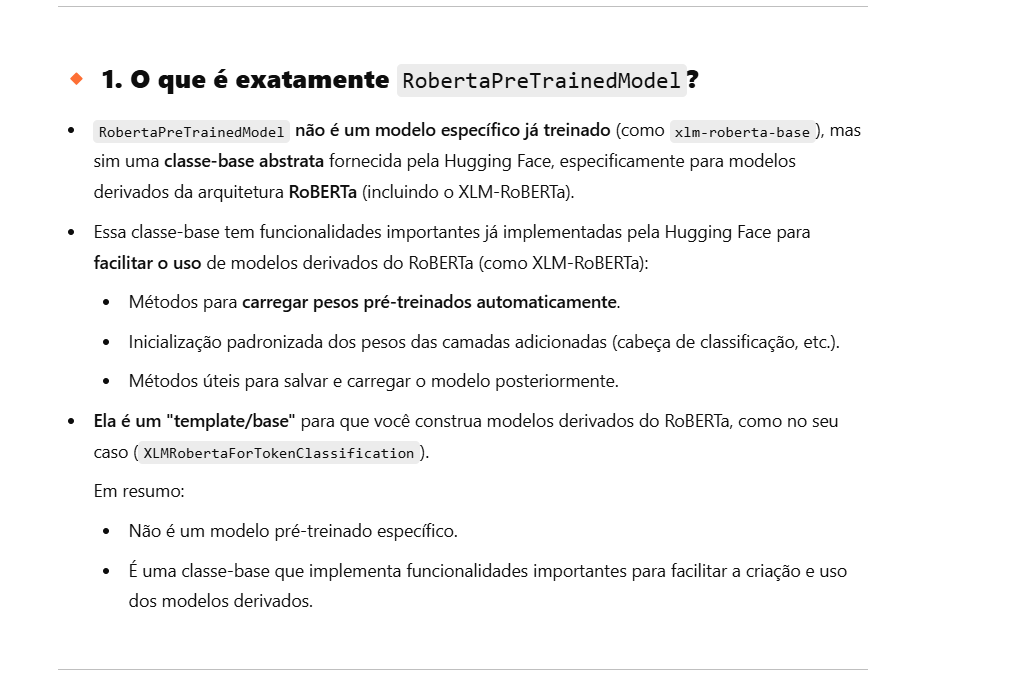

In [ ]:
# vamos criar um classificador NER partindo do body de um XLM BERT e vamos construir  a cabeça de classificação
# isso é importante para ganhar autonomia na solução de problemas usando corpos pré-treinados do BERT

import torch.nn as nn
from transformers import XLMRobertaConfig # → Define os parâmetros do modelo, como número de labels, dropout, tamanho do hidden layer, etc.
from transformers.modeling_outputs import TokenClassifierOutput # Classe usada para estruturar a saída do modelo.
from transformers.models.roberta.modeling_roberta import RobertaModel #Importa o corpo do modelo XLM-RoBERTa pré-treinado.
from transformers.models.roberta.modeling_roberta import RobertaPreTrainedModel #lasse base que fornece funções utilitárias, como carregar pesos pré-treinados.

class XLMRobertaForTokenClassification(RobertaPreTrainedModel):
  #Estamos herdando da classe-base RobertaPreTrainedModel, criada pela Hugging Face especificamente para modelos derivados do RoBERTa (incluindo o XLM-RoBERTa).
  # para acessar o modelo depois vamos chamar algo como model = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=7)
  #A nova classe XLMRobertaForTokenClassification herda de RobertaPreTrainedModel, garantindo que possa carregar os pesos pré-treinados corretamente.
    config_class = XLMRobertaConfig # resgata as configurações do modelo

    def __init__(self, config):
        super().__init__(config) # chamamos a inicialização de RobertaPreTrainedModel e conseguimos os pesos pre treinados
        self.num_labels = config.num_labels # puxa o numero de rotulos disponiveis para classificação
        # Load model body
        self.roberta = RobertaModel(config, add_pooling_layer=False) # DEFINE A ARQUITETURA DO MODELO
        #Essa linha simplesmente constrói a estrutura (arquitetura) do modelo, com as camadas corretas, o número de parâmetros
        #definidos (tamanho de embedding, número de cabeças, número de camadas, etc.) a partir da configuração (config).
        #Os pesos iniciais são aleatórios. (vmaos carregar os pesos depois em model = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", config=config))
        #Na prática, ao herdar de RobertaPreTrainedModel com uma configuração do XLMRobertaConfig, esta linha carregará o corpo do modelo XLM-RoBERTa corretamente, pois estamos usando especificamente a configuração correta.
        # carrega o XML roberta pre treinado, mas sem a pooling layer. A pooling layer classifica sentenças e aqui vamos classificar tokens (retiramos 0 cls e sep )
        # Set up token classification head
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels) #Conecta a saída do modelo (hidden_size = 768) à classificação de tokens (num_labels = número de classes).
        #é uma rede neural, mas extremamente simples: apenas uma camada linear.
        # cada token vai receber uma classificação para cada classe
        # Load and initialize weights
        self.init_weights() # inicializa os pesos das novas camadas adicionadas (como a camada de classificação) com valores padrões ou aleatórios seguindo as práticas recomendadas pela Hugging Face.
        # no livro diz que com esse nos herdamos os pesos do roberta e inicializamos os pesos novos da camada linear

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                labels=None, **kwargs):
      #token_type_ids: usado em modelos que distinguem dois tipos de sequências (ex.: em perguntas/respostas). XLM-RoBERTa não usa isso, então normalmente fica como None.
#**kwargs: permite passar outros argumentos adicionais para o modelo sem precisar listá-los explicitamente.
#input_ids → IDs dos tokens.
#attention_mask → Máscara para ignorar tokens [PAD] durante o treino.
#token_type_ids → Diferencia partes do texto (não usado no RoBERTa).
#labels → (Opcional) Rótulos verdadeiros para cada token.

        # Use model body to get encoder representations
        outputs = self.roberta(input_ids, attention_mask=attention_mask,
                               token_type_ids=token_type_ids, **kwargs)# aqui passamos os input_ids e retornamos os hidden states dos tokens
                               #outputs contém as saídas do encoder.
        # Apply classifier to encoder representation
        sequence_output = self.dropout(outputs[0]) # Contém os hidden states do último bloco do modelo.
        #Não é apenas um bloco; são embeddings contextuais separados para todos os tokens da frase.
        # A primeira posição (outputs[0]) contém os hidden states finais de cada token. Ou seja, cada token tem um vetor de embedding contextualmente enriquecido.
        #O dropout "desativa" aleatoriamente alguns elementos dos embeddings (não tokens inteiros, apenas partes dos embeddings).
        # note que o dropout acontece antes de entrar na camda de classificaçao
        logits = self.classifier(sequence_output) #A camada classifier gera os logits, que são as previsões não normalizadas para cada classe.


        # Calculate losses
        loss = None #É uma prática comum para garantir que a variável esteja definida mesmo quando labels não são fornecidos.
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1)) #Transformamos os tensores para formato (-1, num_labels) para que CrossEntropyLoss funcione corretamente.

       #CrossEntropyLoss espera os tensores no formato [batch_size * seq_len, num_labels] para logits, e [batch_size * seq_len] para labels.
       #view(-1, ...) garante que os tensores sejam "achatados" corretamente antes de calcular a perda.
       #Antes: (batch_size, seq_len, num_labels) → Depois: (batch_size * seq_len, num_labels)
        #Antes: (batch_size, seq_len) → Depois: (batch_size * seq_len)

        # Return model output object
        return TokenClassifierOutput(loss=loss, logits=logits,
                                     hidden_states=outputs.hidden_states,
                                     attentions=outputs.attentions) #A saída não gera um modelo novo; é um objeto que retorna múltiplos valores de forma estruturada:

      #loss → Se labels forem fornecidos, retorna a perda (None se não estiver treinando).
#logits → As previsões para cada token.
#hidden_states → Representações intermediárias do modelo (úteis para debugging).
#attentions → Pesos de atenção dos tokens.

### Loading a Custom Model

In [ ]:
# vamos obter as classes e os indices das classes atraves do tags
index2tag = {idx: tag for idx, tag in enumerate(tags.names)}
tag2index = {tag: idx for idx, tag in enumerate(tags.names)}

In [ ]:
# Ants de instanciar o modelo precisamos carregar suas configurações e definir as classes do problema e o idx 2 class e class 2 indx
# hide_output
from transformers import AutoConfig
#
xlmr_config = AutoConfig.from_pretrained(xlmr_model_name,
                                         num_labels=tags.num_classes,
                                         id2label=index2tag, label2id=tag2index) # temos que passar in to label e label 2 index

# ao usar Autoconfig.from_pretrained nós acabamos puxando todas as configurações do nosso modelo
# com isso vamos garntir que a saida do nosso classificador tenha as 7 classes e facilita o carregamento e salvamento futuro do modelo
#A configuração (xlmr_config) será usada para instanciar seu modelo personalizado:  model = XLMRobertaForTokenClassification.from_pretrained(
  #  xlmr_model_name,
   # config=xlmr_config
#)

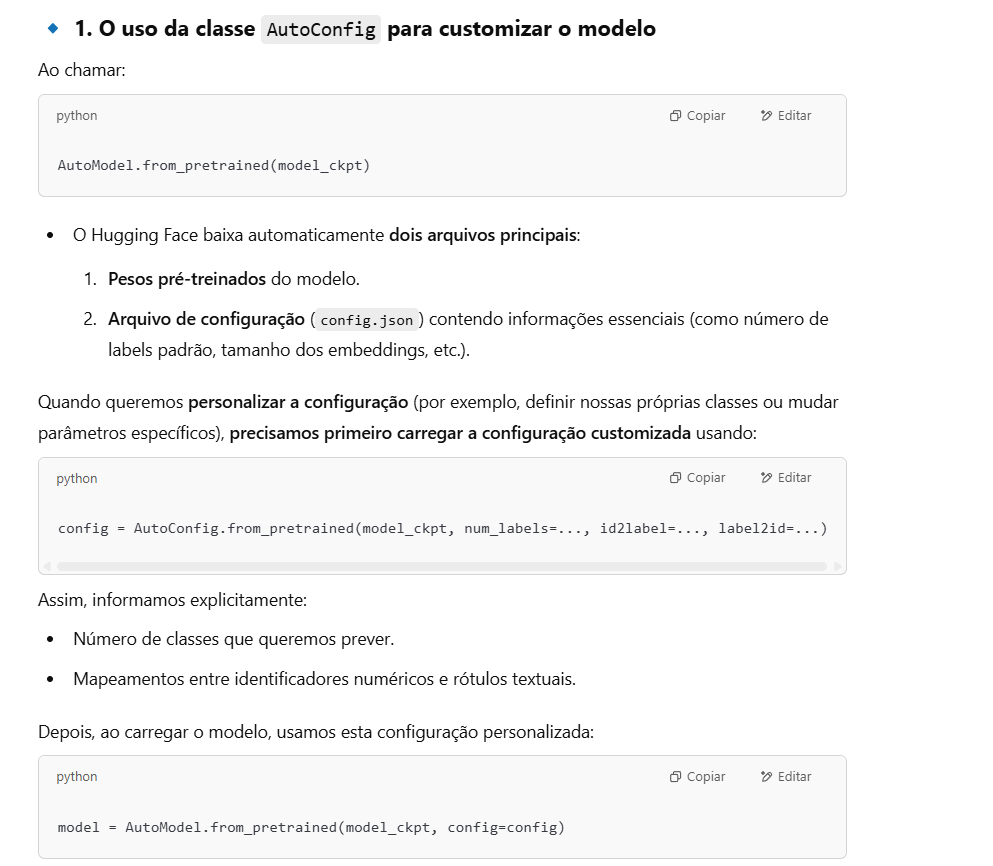

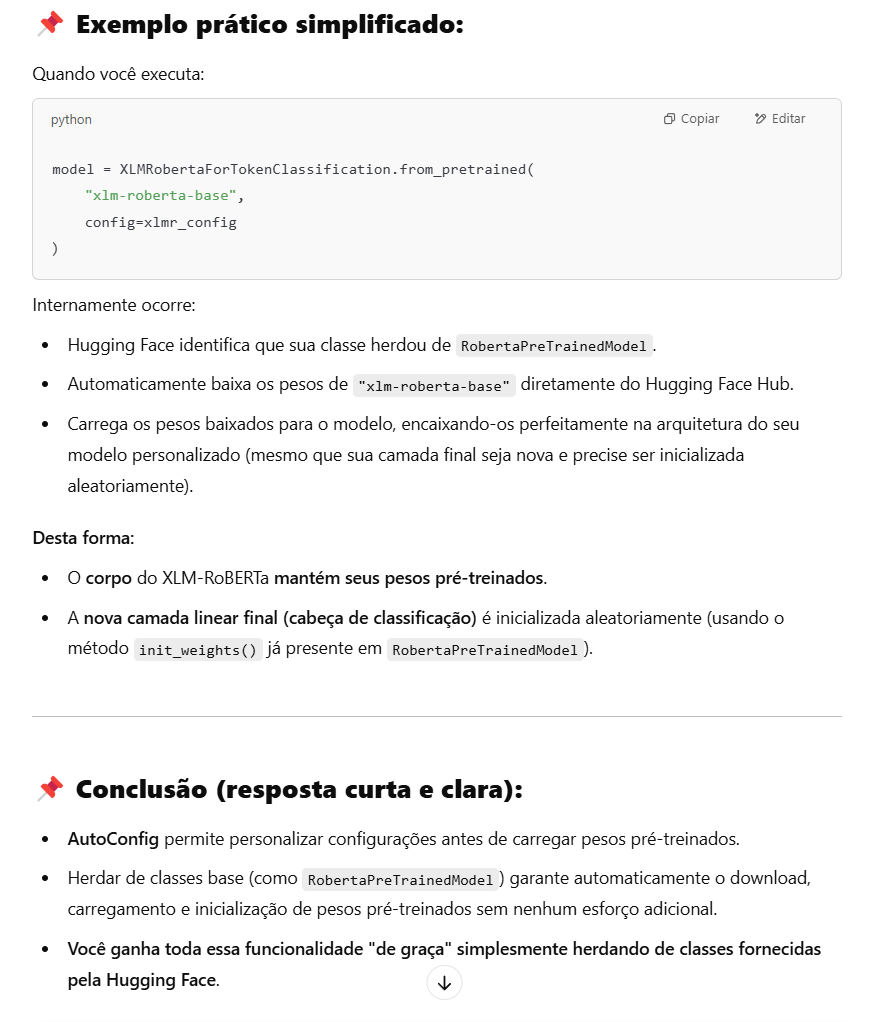

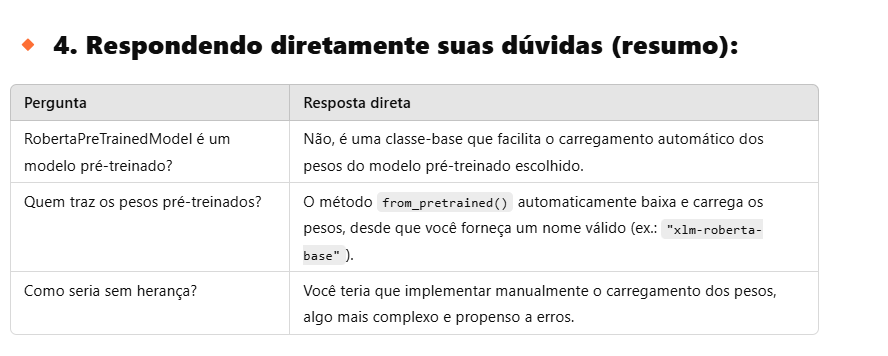

In [ ]:
# hide_output
import torch
# vamos carregar os pesos do moedlo com as configurações definidas
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xlmr_model = (XLMRobertaForTokenClassification
              .from_pretrained(xlmr_model_name, config=xlmr_config)
              .to(device))
# é essencial garantir que os dados e o modelo estejam no mesmo dispositivo
# o modelo, os inputs ids, as mascaras e os labels devem estar no mesmo dispositivo



In [ ]:
# vamos obter as previsoes para o modelo criado
# hide_output
input_ids = xlmr_tokenizer.encode(text, return_tensors="pt")
pd.DataFrame([xlmr_tokens, input_ids[0].numpy()], index=["Tokens", "Input IDs"])

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Input IDs,0,21763,37456,15555,5161,7,2356,5753,38,2


In [ ]:
# vamos agora gerar os outputs
outputs = xlmr_model(input_ids.to(device)).logits # veja que na nossa saida do modelo criado podemos puxar os logits
predictions = torch.argmax(outputs, dim=-1) # veirficamos a previsao
print(f"Number of tokens in sequence: {len(xlmr_tokens)}")
print(f"Shape of outputs: {outputs.shape}")
print(f"Shape of prediction: {predictions.shape}")

Number of tokens in sequence: 10
Shape of outputs: torch.Size([1, 10, 7])


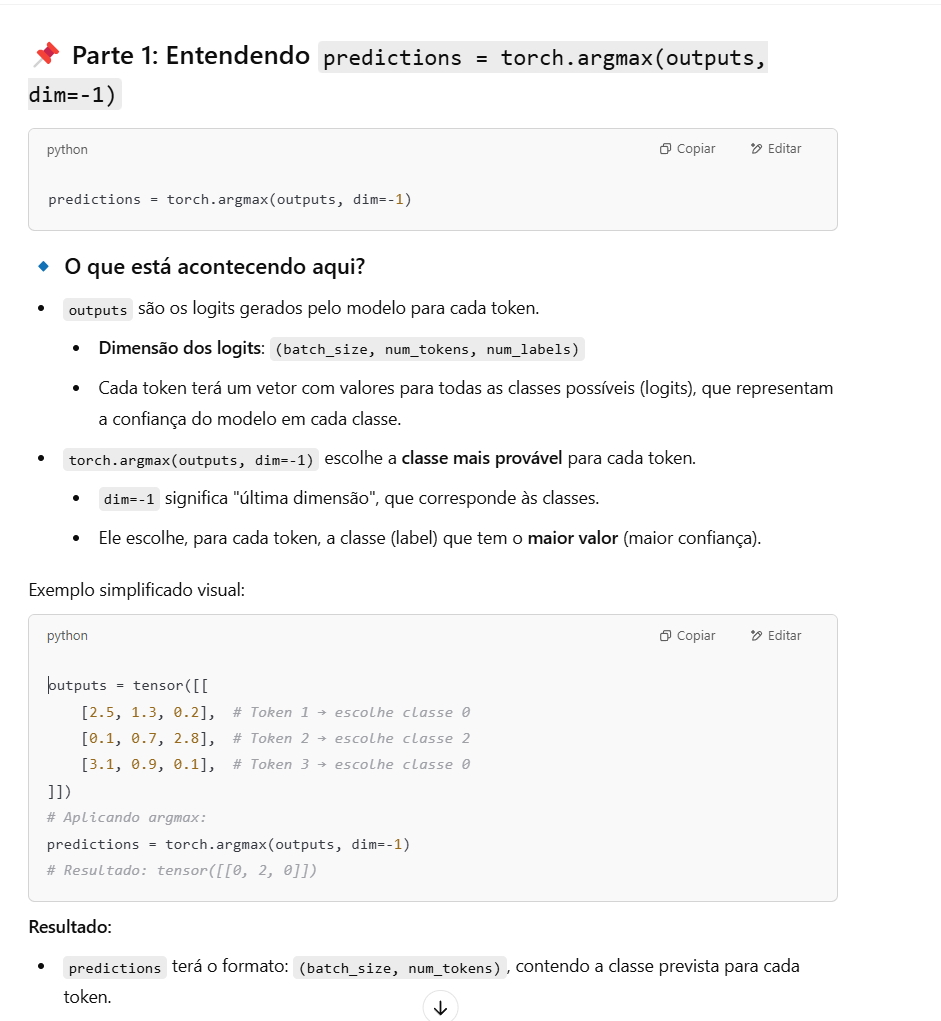

In [ ]:
preds = [tags.names[p] for p in predictions[0].cpu().numpy()] # traduz números das classes em nomes legíveis
pd.DataFrame([xlmr_tokens, preds], index=["Tokens", "Tags"])

# AS PREDIÇÕES FORAM MUITO RUINS PORQUE AINDA NAO TREINAMOS NOSSO MODELO (A CABEÇA DE CLASSIFICAÇÃO)

,0,1,2,3,4,5,6,7,8,9
Tokens,<s>,▁Jack,▁Spar,row,▁love,s,▁New,▁York,!,</s>
Tags,O,I-LOC,B-LOC,B-LOC,O,I-LOC,O,O,I-LOC,B-LOC


In [ ]:
# vamos salvar a função que sera util no futuri

def tag_text(text, tags, model, tokenizer):
    # Get tokens with special characters
    tokens = tokenizer(text).tokens()
    # Encode the sequence into IDs
    input_ids = xlmr_tokenizer(text, return_tensors="pt").input_ids.to(device)
    # Get predictions as distribution over 7 possible classes
    outputs = model(input_ids)[0]
    # Take argmax to get most likely class per token
    predictions = torch.argmax(outputs, dim=2)
    # Convert to DataFrame
    preds = [tags.names[p] for p in predictions[0].cpu().numpy()]
    return pd.DataFrame([tokens, preds], index=["Tokens", "Tags"])


## Tokenizing Texts for NER
**Antes de iniciarmos o treinamento do modelo presisamos tokenizar os inputs e preparar as labels**

In [ ]:
words, labels = de_example["tokens"], de_example["ner_tags"]

In [ ]:
tokenized_input = xlmr_tokenizer(de_example["tokens"], is_split_into_words=True)
tokens = xlmr_tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [ ]:
#hide_output
pd.DataFrame([tokens], index=["Tokens"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>


In [ ]:
# hide_output
word_ids = tokenized_input.word_ids()
pd.DataFrame([tokens, word_ids], index=["Tokens", "Word IDs"])

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None


In [ ]:
#hide_output
previous_word_idx = None
label_ids = []

for word_idx in word_ids:
    if word_idx is None or word_idx == previous_word_idx:
        label_ids.append(-100)
    elif word_idx != previous_word_idx:
        label_ids.append(labels[word_idx])
    previous_word_idx = word_idx

labels = [index2tag[l] if l != -100 else "IGN" for l in label_ids]
index = ["Tokens", "Word IDs", "Label IDs", "Labels"]

pd.DataFrame([tokens, word_ids, label_ids, labels], index=index)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Tokens,<s>,▁2.000,▁Einwohner,n,▁an,▁der,▁Dan,zi,ger,▁Buch,...,▁Wo,i,wod,schaft,▁Po,mmer,n,▁,.,</s>
Word IDs,None,0,1,1,2,3,4,4,4,5,...,9,9,9,9,10,10,10,11,11,None
Label IDs,-100,0,0,-100,0,0,5,-100,-100,6,...,5,-100,-100,-100,6,-100,-100,0,-100,-100
Labels,IGN,O,O,IGN,O,O,B-LOC,IGN,IGN,I-LOC,...,B-LOC,IGN,IGN,IGN,I-LOC,IGN,IGN,O,IGN,IGN


In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = xlmr_tokenizer(examples["tokens"], truncation=True,
                                      is_split_into_words=True)
    labels = []
    for idx, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=idx)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
def encode_panx_dataset(corpus):
    return corpus.map(tokenize_and_align_labels, batched=True,
                      remove_columns=['langs', 'ner_tags', 'tokens'])

In [ ]:
# hide_output
panx_de_encoded = encode_panx_dataset(panx_ch["de"])

## Performance Measures

In [ ]:
from seqeval.metrics import classification_report

y_true = [["O", "O", "O", "B-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
y_pred = [["O", "O", "B-MISC", "I-MISC", "I-MISC", "I-MISC", "O"],
          ["B-PER", "I-PER", "O"]]
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [ ]:
import numpy as np

def align_predictions(predictions, label_ids):
    preds = np.argmax(predictions, axis=2)
    batch_size, seq_len = preds.shape
    labels_list, preds_list = [], []

    for batch_idx in range(batch_size):
        example_labels, example_preds = [], []
        for seq_idx in range(seq_len):
            # Ignore label IDs = -100
            if label_ids[batch_idx, seq_idx] != -100:
                example_labels.append(index2tag[label_ids[batch_idx][seq_idx]])
                example_preds.append(index2tag[preds[batch_idx][seq_idx]])

        labels_list.append(example_labels)
        preds_list.append(example_preds)

    return preds_list, labels_list

## Fine-Tuning XLM-RoBERTa

In [ ]:
# hide_output
from transformers import TrainingArguments

num_epochs = 3
batch_size = 24
logging_steps = len(panx_de_encoded["train"]) // batch_size
model_name = f"{xlmr_model_name}-finetuned-panx-de"
training_args = TrainingArguments(
    output_dir=model_name, log_level="error", num_train_epochs=num_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size, evaluation_strategy="epoch",
    save_steps=1e6, weight_decay=0.01, disable_tqdm=False,
    logging_steps=logging_steps, push_to_hub=True)

In [ ]:
#hide_output
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from seqeval.metrics import f1_score

def compute_metrics(eval_pred):
    y_pred, y_true = align_predictions(eval_pred.predictions,
                                       eval_pred.label_ids)
    return {"f1": f1_score(y_true, y_pred)}

In [ ]:
from transformers import DataCollatorForTokenClassification

data_collator = DataCollatorForTokenClassification(xlmr_tokenizer)

In [ ]:
def model_init():
    return (XLMRobertaForTokenClassification
            .from_pretrained(xlmr_model_name, config=xlmr_config)
            .to(device))

In [ ]:
#hide
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [ ]:
# hide_output
from transformers import Trainer

trainer = Trainer(model_init=model_init, args=training_args,
                  data_collator=data_collator, compute_metrics=compute_metrics,
                  train_dataset=panx_de_encoded["train"],
                  eval_dataset=panx_de_encoded["validation"],
                  tokenizer=xlmr_tokenizer)

CODECARBON : No CPU tracking mode found. Falling back on CPU constant mode.
CODECARBON : Failed to match CPU TDP constant. Falling back on a global constant.
/home/lewtun/miniconda3/envs/book/lib/python3.7/site-packages/apscheduler/util.py:95: PytzUsageWarning: The zone attribute is specific to pytz's interface; please migrate to a new time zone provider. For more details on how to do so, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  if obj.zone == 'local':


In [ ]:
#hide_input
trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
# hide_input
df = pd.DataFrame(trainer.state.log_history)[['epoch','loss' ,'eval_loss', 'eval_f1']]
df = df.rename(columns={"epoch":"Epoch","loss": "Training Loss", "eval_loss": "Validation Loss", "eval_f1":"F1"})
df['Epoch'] = df["Epoch"].apply(lambda x: round(x))
df['Training Loss'] = df["Training Loss"].ffill()
df[['Validation Loss', 'F1']] = df[['Validation Loss', 'F1']].bfill().ffill()
df.drop_duplicates()

Epoch,Training Loss,Validation Loss,F1
1,0.2652,0.160244,0.822974
2,0.1314,0.137195,0.852747
3,0.0806,0.138774,0.864591


In [ ]:
# hide_output
text_de = "Jeff Dean ist ein Informatiker bei Google in Kalifornien"
tag_text(text_de, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁ist,▁ein,▁Informati,ker,▁bei,▁Google,▁in,▁Kaliforni,en,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,O,B-ORG,O,B-LOC,I-LOC,O


## Error Analysis

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Convert dict of lists to list of dicts suitable for data collator
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    # Pad inputs and labels and put all tensors on device
    batch = data_collator(features)
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)
    with torch.no_grad():
        # Pass data through model
        output = trainer.model(input_ids, attention_mask)
        # Logit.size: [batch_size, sequence_length, classes]
        # Predict class with largest logit value on classes axis
        predicted_label = torch.argmax(output.logits, axis=-1).cpu().numpy()
    # Calculate loss per token after flattening batch dimension with view
    loss = cross_entropy(output.logits.view(-1, 7),
                         labels.view(-1), reduction="none")
    # Unflatten batch dimension and convert to numpy array
    loss = loss.view(len(input_ids), -1).cpu().numpy()

    return {"loss":loss, "predicted_label": predicted_label}

In [ ]:
# hide_output
valid_set = panx_de_encoded["validation"]
valid_set = valid_set.map(forward_pass_with_label, batched=True, batch_size=32)
df = valid_set.to_pandas()

  0%|          | 0/197 [00:00<?, ?ba/s]

In [ ]:
# hide_output
index2tag[-100] = "IGN"
df["input_tokens"] = df["input_ids"].apply(
    lambda x: xlmr_tokenizer.convert_ids_to_tokens(x))
df["predicted_label"] = df["predicted_label"].apply(
    lambda x: [index2tag[i] for i in x])
df["labels"] = df["labels"].apply(
    lambda x: [index2tag[i] for i in x])
df['loss'] = df.apply(
    lambda x: x['loss'][:len(x['input_ids'])], axis=1)
df['predicted_label'] = df.apply(
    lambda x: x['predicted_label'][:len(x['input_ids'])], axis=1)
df.head(1)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,"[1, 1, 1, 1, 1, 1, 1]","[0, 10699, 11, 15, 16104, 1388, 2]","[IGN, B-ORG, IGN, I-ORG, I-ORG, I-ORG, IGN]","[0.0, 0.014679872, 0.0, 0.009469474, 0.0103934...","[I-ORG, B-ORG, I-ORG, I-ORG, I-ORG, I-ORG, I-ORG]","[<s>, ▁Ham, a, ▁(, ▁Unternehmen, ▁), </s>]"


In [ ]:
# hide_output
df_tokens = df.apply(pd.Series.explode)
df_tokens = df_tokens.query("labels != 'IGN'")
df_tokens["loss"] = df_tokens["loss"].astype(float).round(2)
df_tokens.head(7)

,attention_mask,input_ids,labels,loss,predicted_label,input_tokens
0,1,10699,B-ORG,0.01,B-ORG,▁Ham
0,1,15,I-ORG,0.01,I-ORG,▁(
0,1,16104,I-ORG,0.01,I-ORG,▁Unternehmen
0,1,1388,I-ORG,0.01,I-ORG,▁)
1,1,56530,O,0.00,O,▁WE
1,1,83982,B-ORG,0.34,B-ORG,▁Luz
1,1,10,I-ORG,0.45,I-ORG,▁a


In [ ]:
(
    df_tokens.groupby("input_tokens")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)  # Get rid of multi-level columns
    .sort_values(by="sum", ascending=False)
    .reset_index()
    .round(2)
    .head(10)
    .T
)

,0,1,2,3,4,5,6,7,8,9
input_tokens,▁,▁der,▁in,▁von,▁/,▁und,▁(,▁),▁'',▁A
count,6066,1388,989,808,163,1171,246,246,2898,125
mean,0.03,0.1,0.14,0.14,0.64,0.08,0.3,0.29,0.02,0.44
sum,200.71,138.05,137.33,114.92,104.28,99.15,74.49,72.35,59.31,54.48


In [ ]:
(
    df_tokens.groupby("labels")[["loss"]]
    .agg(["count", "mean", "sum"])
    .droplevel(level=0, axis=1)
    .sort_values(by="mean", ascending=False)
    .reset_index()
    .round(2)
    .T
)

,0,1,2,3,4,5,6
labels,B-ORG,I-LOC,I-ORG,B-LOC,B-PER,I-PER,O
count,2683,1462,3820,3172,2893,4139,43648
mean,0.66,0.64,0.48,0.35,0.26,0.18,0.03
sum,1769.47,930.94,1850.39,1111.03,760.56,750.91,1354.46


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

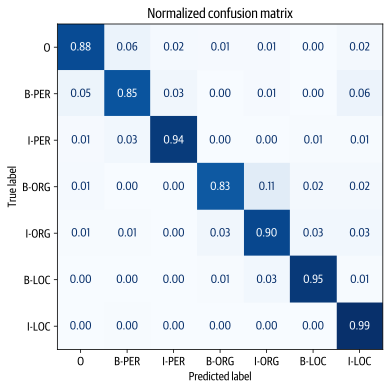

In [ ]:
plot_confusion_matrix(df_tokens["labels"], df_tokens["predicted_label"],
                      tags.names)

In [ ]:
# hide_output
def get_samples(df):
    for _, row in df.iterrows():
        labels, preds, tokens, losses = [], [], [], []
        for i, mask in enumerate(row["attention_mask"]):
            if i not in {0, len(row["attention_mask"])}:
                labels.append(row["labels"][i])
                preds.append(row["predicted_label"][i])
                tokens.append(row["input_tokens"][i])
                losses.append(f"{row['loss'][i]:.2f}")
        df_tmp = pd.DataFrame({"tokens": tokens, "labels": labels,
                               "preds": preds, "losses": losses}).T
        yield df_tmp

df["total_loss"] = df["loss"].apply(sum)
df_tmp = df.sort_values(by="total_loss", ascending=False).head(3)

for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
tokens,▁'',8,.,▁Juli,▁'',▁:,▁Protest,camp,▁auf,▁dem,▁Gelände,▁der,▁Republika,n,ischen,▁Gar,de,</s>
labels,B-ORG,IGN,IGN,I-ORG,I-ORG,I-ORG,I-ORG,IGN,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,IGN,IGN,I-ORG,IGN,IGN
preds,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,O
losses,7.89,0.00,0.00,6.88,8.05,8.68,8.37,0.00,8.65,10.08,8.27,7.90,5.83,0.00,0.00,0.01,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
tokens,▁',▁'',▁Τ,Κ,▁'',▁',▁',▁'',▁T,▁'',▁',ri,▁'',▁',k,▁'',▁',ala,</s>
labels,O,O,O,IGN,O,O,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,I-LOC,I-LOC,IGN,IGN
preds,O,O,B-ORG,O,O,O,O,O,B-ORG,O,O,O,O,O,O,O,O,O,O
losses,0.00,0.00,3.59,0.00,0.00,0.00,10.17,9.22,7.83,7.16,7.23,0.00,7.45,7.75,0.00,7.66,7.78,0.00,0.00


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
tokens,▁United,▁Nations,▁Multi,dimensional,▁Integra,ted,▁Stabil,ization,▁Mission,▁in,▁the,▁Central,▁African,▁Republic,</s>
labels,B-PER,I-PER,I-PER,IGN,I-PER,IGN,I-PER,IGN,I-PER,I-PER,I-PER,I-PER,I-PER,I-PER,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,6.46,5.59,5.51,0.00,5.11,0.00,4.91,0.00,5.18,4.31,4.77,5.32,5.10,4.87,0.00


In [ ]:
# hide_output
df_tmp = df.loc[df["input_tokens"].apply(lambda x: u"\u2581(" in x)].head(2)
for sample in get_samples(df_tmp):
    display(sample)

,0,1,2,3,4,5
tokens,▁Ham,a,▁(,▁Unternehmen,▁),</s>
labels,B-ORG,IGN,I-ORG,I-ORG,I-ORG,IGN
preds,B-ORG,I-ORG,I-ORG,I-ORG,I-ORG,I-ORG
losses,0.01,0.00,0.01,0.01,0.01,0.00


,0,1,2,3,4,5,6,7
tokens,▁Kesk,kül,a,▁(,▁Mart,na,▁),</s>
labels,B-LOC,IGN,IGN,I-LOC,I-LOC,IGN,I-LOC,IGN
preds,B-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC,I-LOC
losses,0.02,0.00,0.00,0.01,0.01,0.00,0.01,0.00


## Cross-Lingual Transfer

In [ ]:
def get_f1_score(trainer, dataset):
    return trainer.predict(dataset).metrics["test_f1"]

In [ ]:
f1_scores = defaultdict(dict)
f1_scores["de"]["de"] = get_f1_score(trainer, panx_de_encoded["test"])
print(f"F1-score of [de] model on [de] dataset: {f1_scores['de']['de']:.3f}")

F1-score of [de] model on [de] dataset: 0.868


In [ ]:
text_fr = "Jeff Dean est informaticien chez Google en Californie"
tag_text(text_fr, tags, trainer.model, xlmr_tokenizer)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Tokens,<s>,▁Jeff,▁De,an,▁est,▁informatic,ien,▁chez,▁Google,▁en,▁Cali,for,nie,</s>
Tags,O,B-PER,I-PER,I-PER,O,O,O,O,B-ORG,O,B-LOC,I-LOC,I-LOC,O


In [ ]:
def evaluate_lang_performance(lang, trainer):
    panx_ds = encode_panx_dataset(panx_ch[lang])
    return get_f1_score(trainer, panx_ds["test"])

In [ ]:
# hide_output
f1_scores["de"]["fr"] = evaluate_lang_performance("fr", trainer)
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

  0%|          | 0/5 [00:00<?, ?ba/s]

F1-score of [de] model on [fr] dataset: 0.714


In [ ]:
# hide_input
print(f"F1-score of [de] model on [fr] dataset: {f1_scores['de']['fr']:.3f}")

F1-score of [de] model on [fr] dataset: 0.714


In [ ]:
# hide_output
f1_scores["de"]["it"] = evaluate_lang_performance("it", trainer)
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

F1-score of [de] model on [it] dataset: 0.692


In [ ]:
# hide_input
print(f"F1-score of [de] model on [it] dataset: {f1_scores['de']['it']:.3f}")

F1-score of [de] model on [it] dataset: 0.692


In [ ]:
#hide_output
f1_scores["de"]["en"] = evaluate_lang_performance("en", trainer)
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

F1-score of [de] model on [en] dataset: 0.589


In [ ]:
#hide_input
print(f"F1-score of [de] model on [en] dataset: {f1_scores['de']['en']:.3f}")

F1-score of [de] model on [en] dataset: 0.589


### When Does Zero-Shot Transfer Make Sense?

In [ ]:
def train_on_subset(dataset, num_samples):
    train_ds = dataset["train"].shuffle(seed=42).select(range(num_samples))
    valid_ds = dataset["validation"]
    test_ds = dataset["test"]
    training_args.logging_steps = len(train_ds) // batch_size

    trainer = Trainer(model_init=model_init, args=training_args,
        data_collator=data_collator, compute_metrics=compute_metrics,
        train_dataset=train_ds, eval_dataset=valid_ds, tokenizer=xlmr_tokenizer)
    trainer.train()
    if training_args.push_to_hub:
        trainer.push_to_hub(commit_message="Training completed!")

    f1_score = get_f1_score(trainer, test_ds)
    return pd.DataFrame.from_dict(
        {"num_samples": [len(train_ds)], "f1_score": [f1_score]})

In [ ]:
# hide_output
panx_fr_encoded = encode_panx_dataset(panx_ch["fr"])

  0%|          | 0/3 [00:00<?, ?ba/s]

In [ ]:
# hide_output
training_args.push_to_hub = False
metrics_df = train_on_subset(panx_fr_encoded, 250)
metrics_df

In [ ]:
#hide_input
# Hack needed to exclude the progress bars in the above cell
metrics_df

,num_samples,f1_score
0,250,0.137329


In [ ]:
# hide_output
for num_samples in [500, 1000, 2000, 4000]:
    metrics_df = metrics_df.append(
        train_on_subset(panx_fr_encoded, num_samples), ignore_index=True)

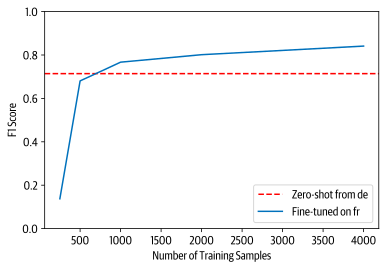

In [ ]:
fig, ax = plt.subplots()
ax.axhline(f1_scores["de"]["fr"], ls="--", color="r")
metrics_df.set_index("num_samples").plot(ax=ax)
plt.legend(["Zero-shot from de", "Fine-tuned on fr"], loc="lower right")
plt.ylim((0, 1))
plt.xlabel("Number of Training Samples")
plt.ylabel("F1 Score")
plt.show()

### Fine-Tuning on Multiple Languages at Once

In [ ]:
from datasets import concatenate_datasets

def concatenate_splits(corpora):
    multi_corpus = DatasetDict()
    for split in corpora[0].keys():
        multi_corpus[split] = concatenate_datasets(
            [corpus[split] for corpus in corpora]).shuffle(seed=42)
    return multi_corpus

In [ ]:
panx_de_fr_encoded = concatenate_splits([panx_de_encoded, panx_fr_encoded])

In [ ]:
# hide_output
training_args.logging_steps = len(panx_de_fr_encoded["train"]) // batch_size
training_args.push_to_hub = True
training_args.output_dir = "xlm-roberta-base-finetuned-panx-de-fr"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=panx_de_fr_encoded["train"],
    eval_dataset=panx_de_fr_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
#hide_output
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

F1-score of [de-fr] model on [de] dataset: 0.866
F1-score of [de-fr] model on [fr] dataset: 0.868
F1-score of [de-fr] model on [it] dataset: 0.815
F1-score of [de-fr] model on [en] dataset: 0.677


In [ ]:
#hide_input
for lang in langs:
    f1 = evaluate_lang_performance(lang, trainer)
    print(f"F1-score of [de-fr] model on [{lang}] dataset: {f1:.3f}")

F1-score of [de-fr] model on [de] dataset: 0.866
F1-score of [de-fr] model on [fr] dataset: 0.868
F1-score of [de-fr] model on [it] dataset: 0.815
F1-score of [de-fr] model on [en] dataset: 0.677


In [ ]:
# hide_output
corpora = [panx_de_encoded]

# Exclude German from iteration
for lang in langs[1:]:
    training_args.output_dir = f"xlm-roberta-base-finetuned-panx-{lang}"
    # Fine-tune on monolingual corpus
    ds_encoded = encode_panx_dataset(panx_ch[lang])
    metrics = train_on_subset(ds_encoded, ds_encoded["train"].num_rows)
    # Collect F1-scores in common dict
    f1_scores[lang][lang] = metrics["f1_score"][0]
    # Add monolingual corpus to list of corpora to concatenate
    corpora.append(ds_encoded)

In [ ]:
corpora_encoded = concatenate_splits(corpora)

In [ ]:
# hide_output
training_args.logging_steps = len(corpora_encoded["train"]) // batch_size
training_args.output_dir = "xlm-roberta-base-finetuned-panx-all"

trainer = Trainer(model_init=model_init, args=training_args,
    data_collator=data_collator, compute_metrics=compute_metrics,
    tokenizer=xlmr_tokenizer, train_dataset=corpora_encoded["train"],
    eval_dataset=corpora_encoded["validation"])

trainer.train()
trainer.push_to_hub(commit_message="Training completed!")

In [ ]:
# hide_output
for idx, lang in enumerate(langs):
    f1_scores["all"][lang] = get_f1_score(trainer, corpora[idx]["test"])

In [ ]:
scores_data = {"de": f1_scores["de"],
               "each": {lang: f1_scores[lang][lang] for lang in langs},
               "all": f1_scores["all"]}
f1_scores_df = pd.DataFrame(scores_data).T.round(4)
f1_scores_df.rename_axis(index="Fine-tune on", columns="Evaluated on",
                         inplace=True)
f1_scores_df

Evaluated on,de,fr,it,en
Fine-tune on,,,,
de,0.8677,0.7141,0.6923,0.5890
each,0.8677,0.8505,0.8192,0.7068
all,0.8682,0.8647,0.8575,0.7870


## Interacting with Model Widgets

<img alt="A Hub widget" caption="Example of a widget on the Hugging Face Hub" src="https://github.com/CassioLima09/NLP_with_Transformers/blob/main/images/chapter04_ner-widget.png?raw=1" id="ner-widget"/>  

## Conclusion